In [1]:
from transformers import DetrFeatureExtractor
import PIL.Image

#数据预处理工具
feature_extractor = DetrFeatureExtractor.from_pretrained(
    'facebook/detr-resnet-50')

print(feature_extractor)

#试算
feature_extractor(
    images=[
        PIL.Image.new('RGB', (100, 100), 'white'),
        PIL.Image.new('RGB', (200, 100), 'white')
    ],
    annotations=[{
        'image_id':
        0,
        'annotations': [{
            'category_id': 0,
            'area': 1,
            'bbox': [1, 2, 3, 4],
        }, {
            'category_id': 0,
            'area': 1,
            'bbox': [1, 2, 3, 4],
        }]
    }, {
        'image_id':
        0,
        'annotations': [{
            'category_id': 0,
            'area': 1,
            'bbox': [1, 2, 3, 4],
        }]
    }],
    return_tensors='pt',
)

DetrFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "DetrFeatureExtractor",
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "max_size": 1333,
  "size": 800
}



{'pixel_values': tensor([[[[2.2489, 2.2489, 2.2489,  ..., 0.0000, 0.0000, 0.0000],
          [2.2489, 2.2489, 2.2489,  ..., 0.0000, 0.0000, 0.0000],
          [2.2489, 2.2489, 2.2489,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 0.0000, 0.0000, 0.0000],
          [2.2489, 2.2489, 2.2489,  ..., 0.0000, 0.0000, 0.0000],
          [2.2489, 2.2489, 2.2489,  ..., 0.0000, 0.0000, 0.0000]],

         [[2.4286, 2.4286, 2.4286,  ..., 0.0000, 0.0000, 0.0000],
          [2.4286, 2.4286, 2.4286,  ..., 0.0000, 0.0000, 0.0000],
          [2.4286, 2.4286, 2.4286,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 0.0000, 0.0000, 0.0000],
          [2.4286, 2.4286, 2.4286,  ..., 0.0000, 0.0000, 0.0000],
          [2.4286, 2.4286, 2.4286,  ..., 0.0000, 0.0000, 0.0000]],

         [[2.6400, 2.6400, 2.6400,  ..., 0.0000, 0.0000, 0.0000],
          [2.6400, 2.6400, 2.6400,  ..., 0.0000, 0.0000, 0.0000],
          [2.6400, 2.6400

In [2]:
from datasets import load_dataset

#加载数据
dataset = load_dataset(path='biglam/nls_chapbook_illustrations',
                       name='illustration-detection',
                       split='train')

#采样
dataset = dataset.shuffle(1).select(range(7000))

dataset, dataset[1]

Reusing dataset nls_chapbook_illustrations (/root/.cache/huggingface/datasets/biglam___nls_chapbook_illustrations/illustration-detection/1.0.0/bab1989ea05996f5c8c55e1c10c0209b2936cb1ec3faa2f89a7ed7cab0193ea4)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/biglam___nls_chapbook_illustrations/illustration-detection/1.0.0/bab1989ea05996f5c8c55e1c10c0209b2936cb1ec3faa2f89a7ed7cab0193ea4/cache-ba406149564fb567.arrow


(Dataset({
     features: ['image_id', 'image', 'width', 'height', 'objects'],
     num_rows: 7000
 }),
 {'image_id': 35194,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x942 at 0x7F7B6FF947B8>,
  'width': 600,
  'height': 942,
  'objects': [{'category_id': 0,
    'image_id': '35194',
    'id': 2933,
    'area': 196536,
    'bbox': [53.0, 335.0, 431.0, 456.0],
    'segmentation': [[53.0, 335.0, 484.0, 335.0, 484.0, 791.0, 53.0, 791.0]],
    'iscrowd': False}]})

In [3]:
import torch


#数据整理函数
def collate_fn(data):
    images = [i['image'] for i in data]

    #把数据格式转换成coco格式,这是个非常蛋疼的格式
    annotations = []
    for i in data:
        annotations.append({
            'image_id': i['image_id'],
            'annotations': i['objects']
        })

    #编码
    data = feature_extractor(images=images,
                             annotations=annotations,
                             return_tensors='pt')

    return data


loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=4,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

for i, data in enumerate(loader):
    break

print(len(loader))

data['pixel_values'].shape, data['pixel_mask'].shape, data['labels'][0]

1750


(torch.Size([4, 3, 1333, 798]),
 torch.Size([4, 1333, 798]),
 {'boxes': tensor([[0.4375, 0.5834, 0.8183, 0.3327]]),
  'class_labels': tensor([0]),
  'image_id': tensor([40021]),
  'area': tensor([281616.1562]),
  'iscrowd': tensor([0]),
  'orig_size': tensor([1031,  600]),
  'size': tensor([1333,  776])})

In [4]:
from transformers import DetrForObjectDetection, DetrModel
from transformers.models.detr.modeling_detr import DetrLoss, DetrHungarianMatcher, DetrObjectDetectionOutput

#加载模型
#model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50',num_labels=1,ignore_mismatched_sizes=True)


#定义下游任务模型
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.pretrained = DetrModel.from_pretrained('facebook/detr-resnet-50')

        #分类网络,在物品数量上+1,因为多一个背景类
        self.fc_label = torch.nn.Linear(256, 2)

        self.fc_bbox = torch.nn.Sequential(
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 4),
            torch.nn.Sigmoid(),
        )

        #加载预训练模型的参数
        parameters = DetrForObjectDetection.from_pretrained(
            'facebook/detr-resnet-50',
            num_labels=1,
            ignore_mismatched_sizes=True)

        self.fc_label.load_state_dict(
            parameters.class_labels_classifier.state_dict())

        self.fc_bbox[0].load_state_dict(
            parameters.bbox_predictor.layers[0].state_dict())
        self.fc_bbox[2].load_state_dict(
            parameters.bbox_predictor.layers[1].state_dict())
        self.fc_bbox[4].load_state_dict(
            parameters.bbox_predictor.layers[2].state_dict())

        self.criterion = DetrLoss(matcher=DetrHungarianMatcher(class_cost=1,
                                                               bbox_cost=5,
                                                               giou_cost=2),
                                  num_classes=1,
                                  eos_coef=0.1,
                                  losses=['labels', 'boxes', 'cardinality'])

    def forward(self, pixel_values, pixel_mask, labels=None):
        logits = self.pretrained(pixel_values=pixel_values,
                                 pixel_mask=pixel_mask)

        #[b, 100, 256]
        logits = logits.last_hidden_state

        #[b, 100, 256] -> [b, 100, 2]
        out_label = self.fc_label(logits)
        #[b, 100, 256] -> [b, 100, 4]
        out_bbox = self.fc_bbox(logits)

        loss = None
        if labels:
            #计算loss
            loss = self.criterion({
                'logits': out_label,
                'pred_boxes': out_bbox
            }, labels)

            #loss加权
            loss['loss_ce'] *= 1
            loss['loss_bbox'] *= 5
            loss['loss_giou'] *= 2

            #求和
            loss = sum(loss.values())

        #return {'loss': loss, 'logits': out_label, 'pred_boxes': out_bbox}
        return DetrObjectDetectionOutput(loss=loss,
                                         logits=out_label,
                                         pred_boxes=out_bbox)


model = Model()

#统计参数量
print(sum(i.numel() for i in model.parameters()) / 10000)

with torch.no_grad():
    out = model(**data)

out['loss'], out.keys()

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrModel: ['bbox_predictor.layers.0.weight', 'bbox_predictor.layers.2.bias', 'bbox_predictor.layers.1.weight', 'class_labels_classifier.weight', 'class_labels_classifier.bias', 'bbox_predictor.layers.2.weight', 'bbox_predictor.layers.0.bias', 'bbox_predictor.layers.1.bias']
- This IS expected if you are initializing DetrModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- 

4150.9318


(tensor(101.3537), odict_keys(['loss', 'logits', 'pred_boxes']))

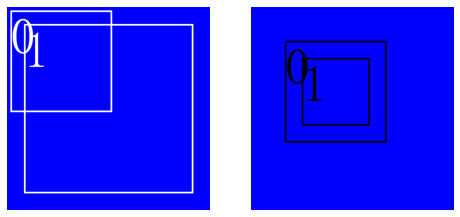

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline


def show(image, target, predict):
    plt.figure(figsize=(8, 4))
    
    copy = image.copy()
    draw = PIL.ImageDraw.Draw(copy)
    font = PIL.ImageFont.truetype('datas/simsun.ttc', 150)

    for i in target:
        i['bbox'][2] += i['bbox'][0]
        i['bbox'][3] += i['bbox'][1]
        draw.rectangle(xy=i['bbox'], outline='white', width=5)
        draw.text(xy=i['bbox'][:2],
                  text=str(i['category_id']),
                  fill='white',
                  font=font)

    plt.subplot(1, 2, 1)
    plt.imshow(copy)
    plt.axis('off')

    copy = image.copy()
    draw = PIL.ImageDraw.Draw(copy)

    for i in predict:
        draw.rectangle(xy=i['box'], outline='black', width=5)
        draw.text(xy=i['box'][:2],
                  text=str(i['label']),
                  fill='black',
                  font=font)

    plt.subplot(1, 2, 2)
    plt.imshow(copy)
    plt.axis('off')
    plt.show()


target = [{
    'category_id': 0,
    'bbox': [10, 10, 300, 300],
}, {
    'category_id': 1,
    'bbox': [50, 50, 500, 500],
}]

predict = [{
    'label': 0,
    'box': [100, 100, 400, 400]
}, {
    'label': 1,
    'box': [150, 150, 350, 350]
}]

show(PIL.Image.new('RGB', (600, 600), 'blue'), target, predict)

In [6]:
def test():
    #加载数据集
    dataset_test = load_dataset(path='biglam/nls_chapbook_illustrations',
                                name='illustration-detection',
                                split='train')

    #采样
    dataset_test = dataset_test.shuffle(1).select(
        range(7000, len(dataset_test)))

    dataset_test = dataset_test.shuffle()

    for i in range(15):
        image = dataset_test[i]['image']
        target = dataset_test[i]['objects']

        data = feature_extractor(images=image, return_tensors='pt')
        with torch.no_grad():
            out = model(**data)

        #取出图片的原始尺寸,交换长和宽的位置
        target_sizes = torch.LongTensor([image.size[1],
                                         image.size[0]]).unsqueeze(dim=0)

        #把预测的结果缩放到原始图片的尺寸,并计算出分数和label
        out = feature_extractor.post_process(out, target_sizes=target_sizes)[0]

        predict = []
        for j in range(len(out['scores'])):
            if out['scores'][j] < 0.8:
                continue

            predict.append({
                'label': out['labels'][j].item(),
                'box': out['boxes'][j].tolist(),
            })

        print(i)
        show(image, target, predict)


#test()

In [7]:
from transformers import AdamW
from transformers.optimization import get_scheduler
from transformers.trainer_pt_utils import get_parameter_names


#训练
def train():
    global model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    optimizer = AdamW(model.parameters(),
                      lr=2e-5,
                      betas=(0.9, 0.999),
                      eps=1e-8)
    scheduler = get_scheduler(name='linear',
                              num_warmup_steps=0,
                              num_training_steps=len(loader),
                              optimizer=optimizer)

    model.train()
    for i, data in enumerate(loader):
        #设备
        data['pixel_values'] = data['pixel_values'].to(device)
        data['pixel_mask'] = data['pixel_mask'].to(device)
        for label in data['labels']:
            for k in label.keys():
                label[k] = label[k].to(device)

        out = model(**data)
        loss = out['loss']

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        optimizer.zero_grad()
        model.zero_grad()

        if i % 50 == 0:
            lr = optimizer.state_dict()['param_groups'][0]['lr']

            print(i, loss.item(), lr)

    model = model.cpu()
    torch.save(model, 'models/12.目标侦测_找插图.model')


#train()

Reusing dataset nls_chapbook_illustrations (/root/.cache/huggingface/datasets/biglam___nls_chapbook_illustrations/illustration-detection/1.0.0/bab1989ea05996f5c8c55e1c10c0209b2936cb1ec3faa2f89a7ed7cab0193ea4)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/biglam___nls_chapbook_illustrations/illustration-detection/1.0.0/bab1989ea05996f5c8c55e1c10c0209b2936cb1ec3faa2f89a7ed7cab0193ea4/cache-ba406149564fb567.arrow


0


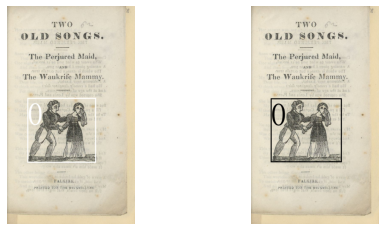

1


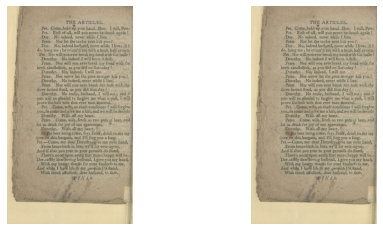

2


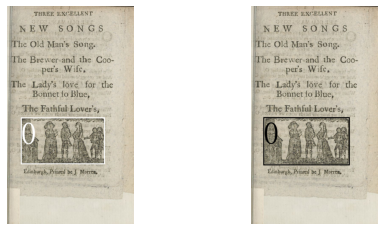

3


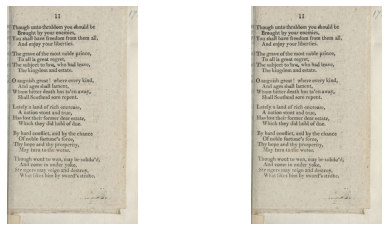

4


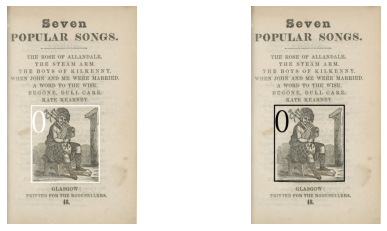

5


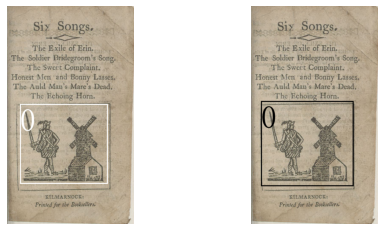

6


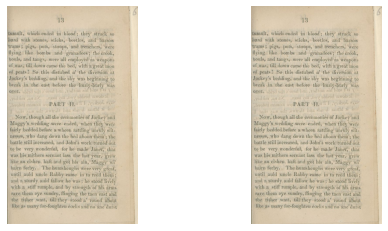

7


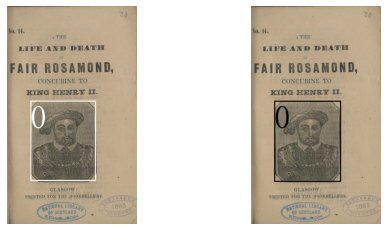

8


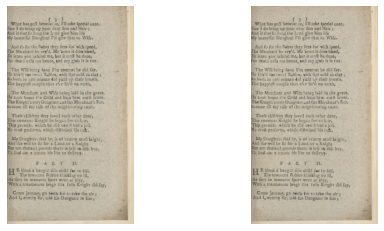

9


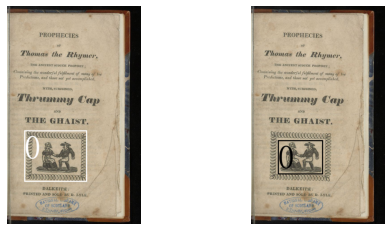

10


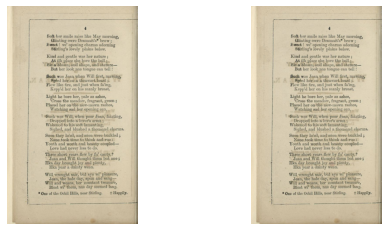

11


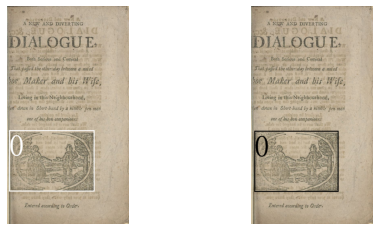

12


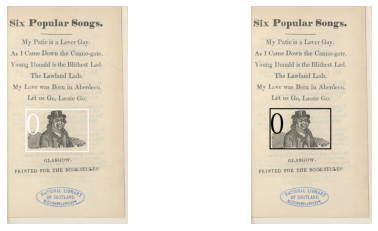

13


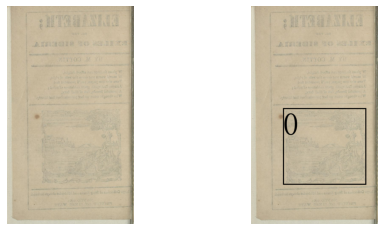

14


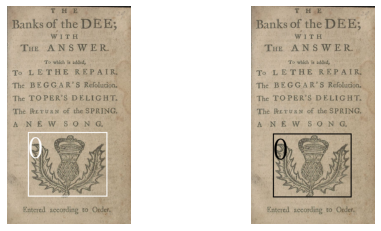

In [8]:
model = torch.load('models/12.目标侦测_找插图.model')

test()